# Set Up Environment
Mount Google Drive.

In [4]:
from google.colab import drive
from shutil import copyfile
import os
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Set up the paths

In [5]:
### Python
import os
import time 
from datetime import datetime
from tqdm import tqdm

### Numpy
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn

### MatplotLib
import matplotlib.pyplot as plt
from scipy.io import loadmat

### Torch
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

### Tensorflow
#import tensorflow as tf
from tensorflow import summary
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Set Device Parameter and Check To Make Sure its the one you want. 🙂

In [6]:
### System Parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"You Are Running on a: {DEVICE}")

You Are Running on a: cuda


# Util Functions

## Dataset 

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
class EducationDataset(torch.utils.data.Dataset):
  '''
  Prepare the Boston dataset for regression
  '''

  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

## Evaluation Metrics


In [9]:
def mse(pred, y):
    assert pred.shape == y.shape, "Shape mismatch"
    
    if type(y) is torch.Tensor:
        mse = torch.mean((y - pred) ** 2)
    else:
        mse = np.mean((y - pred) ** 2)
    return mse

In [10]:
def correlation(pred, y):
    assert pred.shape == y.shape, "Shape mismatch"
    
    if type(y) is torch.Tensor:
        y = y.cpu().detach().numpy()
        pred = pred.cpu().detach().numpy()

    corr = np.corrcoef(y.flatten(), pred.flatten())[0][1]
    return corr

In [11]:
def compute_metrics(pred, y,  metrics=["mse", "corr"]):
    '''
    input: 
      pred: (N) tensor or numpy array
      y: (N) tensor or numpy array
      metric: a list of metrics to compute 
    return:
      results: a dictionary of metrics, each being a single scalar averaged across samples 
    '''
    assert type(pred) == type(y), "Type mismatch"
    assert pred.shape == y.shape, "Shape mismatch"

    results = {}
    if "mse" in metrics:
        results["mse"] = mse(pred, y).item()
    if "corr" in metrics:
        results["corr"] = correlation(pred, y).item()
    return results

## Training Functions


In [12]:
BACKBONE_MODEL = "AE"

In [176]:
def train(model, 
          train_loader, valid_loader,
          criterion,
          optimizer,
          max_epochs,
          patience,
          alpha=None,
          writer=None,
          best_model_weights_file=None,
          eval_interval=1,
          metrics=None,
          eval_fn=None,
          eval_kwargs=None,
          device="cpu"):
  
    since = time.time()
    best_metric, best_metric_epoch = -float('inf'), 0
    prev_valid_loss, trigger_times = 1e100, 0 # record this for early stopping 
    
    for epoch in range(1, max_epochs + 1):

        ### Training 
        model.train()
        training_loss = 0.0 
        with tqdm(train_loader, unit="batch") as tepoch:
        
            for n_batches, batch in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch} / {max_epochs}: ")    
                x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
                
                optimizer.zero_grad() 
                if BACKBONE_MODEL == "MLP":
                    pred = model(x)
                    loss = criterion(y, pred)
                elif BACKBONE_MODEL == "AE":
                    pred, decoded = model(x)
                    loss = criterion(y, pred) + alpha * criterion(decoded, x)
                
                loss.backward() 
                optimizer.step()  
                training_loss += loss.item()
                tepoch.set_postfix(loss=(training_loss/(n_batches+1)))
                
        training_loss /= (n_batches +1)
        if writer: writer.add_scalar("Loss/training", training_loss, epoch)

        ### Validation 
        valid_loss, valid_metrics = eval_fn(model, loader=valid_loader, criterion=criterion, **eval_kwargs)
        if writer: 
            writer.add_scalar("Loss/validation", valid_loss, epoch)
            for metric in metrics:
                writer.add_scalar(metric + "/validation", valid_metrics[metric], epoch)
        msg = "".join([" - val_" + metric + f": {valid_metrics[metric]:.4f}" for metric in metrics])
        print(f"    loss: {training_loss:.4f} - val_loss: {valid_loss:.4f}" + msg)
        
        # save weights of best model so far 
        if valid_metrics['corr'] > best_metric:
            best_metric, best_metric_epoch = valid_loss, epoch
            if best_model_weights_file:
                torch.save(model.state_dict(), best_model_weights_file)
        
        # early stopping 
        if valid_metrics['corr'] < prev_valid_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model
        else:
            trigger_times = 0
        
        prev_valid_loss = valid_metrics['corr']

    ### finish training 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print(f"Best validation metric: {best_metric:.4f} @ Epoch: {best_metric_epoch}")
    if writer: writer.close()

    # load best model weights
    model.load_state_dict(torch.load(best_model_weights_file))

    return model

In [14]:
# validation function 
def evaluate(model,loader,criterion, alpha=None, metrics=["mse", "nmse", "psnr", "ssim"], device="cpu"):
  
  valid_loss, valid_metrics = 0, {}

  with torch.no_grad():
    model.eval() 

    for n_batches, batch in enumerate(loader):
      
      x, y = batch[0].to(device=DEVICE), batch[1].to(device=DEVICE)
      if BACKBONE_MODEL == "MLP":
          pred = model(x)
          loss = criterion(y, pred)
      elif BACKBONE_MODEL == "AE":
          pred, decoded = model(x)
          loss = criterion(y, pred) + alpha * criterion(decoded, x)
      
      metrics = compute_metrics(y, pred, metrics)
      valid_loss += loss.item()

      for metric in metrics:
          if n_batches == 0:
              valid_metrics[metric] = metrics[metric]
          else:
              valid_metrics[metric] += metrics[metric]
            
    valid_loss /= (n_batches+1)
    for metric in metrics:
          valid_metrics[metric] /= (n_batches+1)

  return valid_loss, valid_metrics

## Models

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
def init_weights(net, init_type='xavier', gain=1.0):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('Initialization method {} is not implemented.'.format(init_type))
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, gain)
            nn.init.constant_(m.bias.data, 0.0)
    net.apply(init_func)
    print("Total number of parameters:", count_parameters(net))

In [17]:
class MLP(nn.Module):
  '''
  Multilayer Perceptron for regression.
  '''
  def __init__(self, input_dim):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_dim, 128),
      nn.ReLU(),
      nn.Linear(128, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )

  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [157]:
class supervised_AE(torch.nn.Module):
  def __init__(self, input_dim, latent_dim):
    super().__init__()
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim, int(input_dim * 0.5)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_dim * 0.5), int(input_dim * 0.25)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_dim * 0.25), latent_dim),
        torch.nn.ReLU()
        )
    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(latent_dim, int(input_dim * 0.25)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_dim * 0.25), int(input_dim * 0.5)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_dim * 0.5), input_dim),
        torch.nn.ReLU()
        #torch.nn.Sigmoid()
        )
    self.regressor = nn.Sequential(
      nn.Linear(latent_dim, 1),
    )
  
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    output = self.regressor(encoded)
    return output, decoded

# Model Training


## Config



This will be converted into a config or yaml file


In [167]:
# clear cuda 
torch.cuda.empty_cache()

In [258]:
### Dataset parameters
PROJECT_ROOT="/content/drive/MyDrive/Data Open Championship 2022"
DATA_DIR = "2-data/preprocessed/absolute"
WEIGHTS_DIR = PROJECT_ROOT + "/3-code/checkpoints"
MODEL_NAME = "AE_3layer_completion_total_2.pth"
PRETRAINED_WEIGHTS = None 
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Backbone Unet Parameters
BACKBONE_MODEL="AE"   # "AE"
LATENT_DIM = 5
ALPHA = 0.2 # 0.1

### Data Parameters 
BATCH_SIZE=256                      
NUM_WORKERS=0
PIN_MEMORY=False
SHUFFLE_TRAINING=True

### Preprocessing
STANDARDIZE = False
LOGTRANSFORM = True

### Optimization Parameters
EPOCHS=100              
LEARNING_RATE=0.01       # [0.0001,0.001]
WEIGHT_DECAY=0            # USE 0! 0.1 SEEM TO STOP EARLY
OPTIMIZER="Adam"
MOMENTUM=0.8              
PATIENCE=2               
METRICS=["mse", "corr"]
WRITER=False

EVAL_KEYWORD_ARGS = dict(
    alpha=ALPHA,
    metrics=METRICS,
    device=DEVICE                                     
)

### variable definition 
response = 'completion_total'

predictors_finance = [
  "academic support - current year total",
"academic support - salaries and wages",
"additional (or decreased) pension expense",
"auxiliary enterprises -- current year total",
"auxiliary enterprises -- salaries and wages",
"institutional support - current year total",
"institutional support - salaries and wages",
"instruction - current year total",
"instruction - salaries and wages",
"public service - current year total",
"public service - salaries and wages",
"scholarships and fellowships expenses -- current year total",
"total gross scholarships and fellowships",
"student services - current year total",
"student services - salaries and wages",
 ]

predictors_finance = ["finance_" + col for col in predictors_finance]

predictors_finaid = [
    'finaid_scugrad', 'finaid_uagrntp',
    'finaid_uagrntt','finaid_upgrntp', 
    'finaid_upgrntt', 'finaid_ufloanp', 
    'finaid_ufloant', 'finaid_ugpo9_t',
    'finaid_ugpo9_a', 'finaid_gpo9_t', 'finaid_gpo9_a',
    'finaid_po9_t', 'finaid_po9_a', 
    'finaid_ugdod_t', 'finaid_ugdod_a', 
    'finaid_gdod_t', 'finaid_gdod_a', 'finaid_dod_t'
]

predictors_fee = [
    'fee_tuition1', 'fee_fee1', 'fee_hrchg1', 'fee_tuition2', 'fee_fee2',
       'fee_hrchg2', 'fee_tuition3', 'fee_fee3', 'fee_hrchg3', 'fee_tuition5',
       'fee_fee5', 'fee_hrchg5', 'fee_tuition6', 'fee_fee6', 'fee_hrchg6',
       'fee_tuition7', 'fee_fee7', 'fee_hrchg7', 'fee_chg3tgtd',
       'fee_chg3fgtd', 'fee_chg4ay3', 'fee_chg3ay3', 'fee_chg6ay3',
       'fee_chg7ay3', 'fee_chg8ay3'
]

covariates = [
    'time',
    'charac_medical',
 'charac_urban',
 'charac_landgrant',
 'charac_instsize',
 'charac_openadmission',
 'charac_religion_no',
 'diversity_historicallyblackcollege',
 'diversity_tribal',
 'diversity_disab',
 'diversity_veteranprograms',
 'diversity_athleticprograms',
 'services_hospital',
 'services_remedial',
 'services_counseling',
 'services_employment',
 'services_placement',
 'services_daycare',
 'services_library',
 'services_library_physical',
 'services_library_digital',
 'speclearning_distancecourse',
 'speclearning_distancepogram',
 'speclearning_parttime',
 'speclearning_studyabroad',
 'speclearning_eveningcollege',
 'speclearning_rotc']

print(len(predictors_finance), len(predictors_fee), len(predictors_finaid))
print(len(covariates))

predictors = predictors_finance + predictors_fee + predictors_finaid
INPUT_DIM = len(predictors) + len(covariates)
print(INPUT_DIM)

15 25 18
27
85


## Training prep


In [259]:
if BACKBONE_MODEL == "MLP":
    model = MLP(input_dim=INPUT_DIM).to(DEVICE)
elif BACKBONE_MODEL == "AE":
    model = supervised_AE(input_dim=INPUT_DIM, latent_dim=LATENT_DIM).to(DEVICE)

if PRETRAINED_WEIGHTS:
    model.load_state_dict(torch.load(os.path.join(WEIGHTS_DIR, PRETRAINED_WEIGHTS)))
    print("Loaded pretrained weights from " + PRETRAINED_WEIGHTS)
else:
    # initialize weights using Xavier 
    init_weights(model, "xavier", gain=1.0)

Total number of parameters: 9336


In [260]:
if OPTIMIZER=="RMSProp":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
else:
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [261]:
LOSS_TYPE = "MSE"
if LOSS_TYPE == "MSE":
    criterion = torch.nn.MSELoss().to(DEVICE)
else:
    criterion = torch.nn.L1Loss().to(DEVICE)

In [262]:
import pandas as pd

In [263]:
# Load prepared data 
data_to_folder = os.path.join(PROJECT_ROOT, DATA_DIR)
df_train = pd.read_csv(os.path.join(data_to_folder, 'df_all_pub_train.csv'), index_col=0)
df_test = pd.read_csv(os.path.join(data_to_folder, 'df_all_pub_test.csv'), index_col=0)

# log transform costs
if LOGTRANSFORM:
  for col in predictors_finance + ['finaid_upgrntt', 'finaid_ufloant', 'finaid_ugpo9_t',
      'finaid_gpo9_t', 'finaid_gpo9_a','finaid_po9_t', 'finaid_po9_a', 'finaid_ugdod_a', 
      'finaid_gdod_t', 'finaid_gdod_a', 'finaid_dod_t', 'finaid_ugdod_t']:
      df_train[col] = np.log(df_train[col]+0.1)
      df_test[col] = np.log(df_test[col]+0.1)

# get x and y 
y_train = df_train[response]
y_test = df_test[response]
X_train = df_train[predictors + covariates][~y_train.isnull()]
X_test = df_test[predictors + covariates][~y_test.isnull()]
y_train = np.asarray(y_train[~y_train.isnull()]).reshape(-1,1)
y_test = np.asarray(y_test[~y_test.isnull()]).reshape(-1,1)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# split training into train and validation 
n_train = int(X_train.shape[0] - 0.5 * X_test.shape[0])
X_train_, X_valid = X_train.iloc[:n_train], X_train.iloc[n_train:]
y_train_, y_valid = y_train[:n_train], y_train[n_train:]
print("Train:", X_train_.shape, "  Valid:", X_valid.shape, "   Test:", X_test.shape)

# standardize
if STANDARDIZE:
    scaler = StandardScaler()
    X_train_ = scaler.fit_transform(X_train_)
    X_test = scaler.transform(X_test)
    X_valid = scaler.transform(X_valid)
else:
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    
# data loaders 
train_loader = DataLoader(
    EducationDataset(X_train_, y_train_),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    shuffle=SHUFFLE_TRAINING)

valid_loader = DataLoader(
    EducationDataset(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    shuffle=False)

test_loader = DataLoader(
    EducationDataset(X_test, y_test),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    shuffle=False)

Train: (7038, 85)   Valid: (1005, 85)    Test: (2009, 85)


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [264]:
assert(os.path.exists(WEIGHTS_DIR))
WEIGHT_FILE = os.path.join(WEIGHTS_DIR, MODEL_NAME)
if WRITER:
  LOG_FILE = os.path.join(WEIGHTS_DIR, MODEL_NAME[:-4]+"_"+ datetime.now().strftime("%Y%m%d-%H:%M:%S"))
  writer = SummaryWriter(LOG_FILE)
else:
  writer = None

## Execute Training

In [265]:
model = train(
    model=model.double(),
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    alpha=ALPHA,
    max_epochs=EPOCHS,
    patience=PATIENCE,
    metrics=METRICS,
    writer=writer,
    best_model_weights_file=WEIGHT_FILE,
    eval_fn=evaluate,
    eval_kwargs=EVAL_KEYWORD_ARGS,
    device=DEVICE
)



Epoch 1 / 100: : 100%|██████████| 28/28 [00:00<00:00, 94.55batch/s, loss=1.32e+7]


    loss: 13196741.8757 - val_loss: 9635498.8261 - val_mse: 9635498.6351 - val_corr: 0.7878
Trigger Times: 1


Epoch 2 / 100: : 100%|██████████| 28/28 [00:00<00:00, 95.77batch/s, loss=1.07e+7]


    loss: 10722915.4768 - val_loss: 3174796.1772 - val_mse: 3174795.9765 - val_corr: 0.8043


Epoch 3 / 100: : 100%|██████████| 28/28 [00:00<00:00, 94.42batch/s, loss=3.82e+6]


    loss: 3815356.4335 - val_loss: 1652222.6605 - val_mse: 1652222.4598 - val_corr: 0.8857


Epoch 4 / 100: : 100%|██████████| 28/28 [00:00<00:00, 94.45batch/s, loss=2.26e+6]


    loss: 2257641.3322 - val_loss: 1303103.3873 - val_mse: 1303103.1865 - val_corr: 0.9126


Epoch 5 / 100: : 100%|██████████| 28/28 [00:00<00:00, 97.27batch/s, loss=1.47e+6]


    loss: 1466038.5307 - val_loss: 1315775.6735 - val_mse: 1315775.4728 - val_corr: 0.9278


Epoch 6 / 100: : 100%|██████████| 28/28 [00:00<00:00, 106.74batch/s, loss=1.07e+6]


    loss: 1066018.1969 - val_loss: 1303221.5975 - val_mse: 1303221.3967 - val_corr: 0.9363


Epoch 7 / 100: : 100%|██████████| 28/28 [00:00<00:00, 107.18batch/s, loss=8.79e+5]


    loss: 878911.6911 - val_loss: 1185424.9425 - val_mse: 1185424.7418 - val_corr: 0.9395


Epoch 8 / 100: : 100%|██████████| 28/28 [00:00<00:00, 107.80batch/s, loss=7.58e+5]


    loss: 758225.0058 - val_loss: 1069336.5754 - val_mse: 1069336.3747 - val_corr: 0.9429


Epoch 9 / 100: : 100%|██████████| 28/28 [00:00<00:00, 108.94batch/s, loss=6.98e+5]


    loss: 697851.1130 - val_loss: 1228861.5592 - val_mse: 1228861.3584 - val_corr: 0.9451


Epoch 10 / 100: : 100%|██████████| 28/28 [00:00<00:00, 109.69batch/s, loss=6.66e+5]


    loss: 665910.1010 - val_loss: 1385074.7303 - val_mse: 1385074.5296 - val_corr: 0.9464


Epoch 11 / 100: : 100%|██████████| 28/28 [00:00<00:00, 105.13batch/s, loss=6.36e+5]


    loss: 636490.3178 - val_loss: 1018103.2995 - val_mse: 1018103.0987 - val_corr: 0.9493


Epoch 12 / 100: : 100%|██████████| 28/28 [00:00<00:00, 106.30batch/s, loss=6.08e+5]


    loss: 607819.3524 - val_loss: 944962.6587 - val_mse: 944962.4579 - val_corr: 0.9539


Epoch 13 / 100: : 100%|██████████| 28/28 [00:00<00:00, 109.12batch/s, loss=5.91e+5]


    loss: 590598.7116 - val_loss: 983863.7747 - val_mse: 983863.5740 - val_corr: 0.9529
Trigger Times: 1


Epoch 14 / 100: : 100%|██████████| 28/28 [00:00<00:00, 110.02batch/s, loss=5.71e+5]


    loss: 570979.8061 - val_loss: 1100094.6824 - val_mse: 1100094.4816 - val_corr: 0.9564


Epoch 15 / 100: : 100%|██████████| 28/28 [00:00<00:00, 108.90batch/s, loss=5.48e+5]


    loss: 547852.0822 - val_loss: 1221200.6424 - val_mse: 1221200.4417 - val_corr: 0.9558
Trigger Times: 1


Epoch 16 / 100: : 100%|██████████| 28/28 [00:00<00:00, 107.83batch/s, loss=5.45e+5]


    loss: 544624.1861 - val_loss: 840251.7825 - val_mse: 840251.5817 - val_corr: 0.9574


Epoch 17 / 100: : 100%|██████████| 28/28 [00:00<00:00, 109.59batch/s, loss=5.37e+5]


    loss: 537443.7809 - val_loss: 1058937.6930 - val_mse: 1058937.4923 - val_corr: 0.9550
Trigger Times: 1


Epoch 18 / 100: : 100%|██████████| 28/28 [00:00<00:00, 108.99batch/s, loss=5.21e+5]


    loss: 521314.4157 - val_loss: 1137925.9681 - val_mse: 1137925.7674 - val_corr: 0.9581


Epoch 19 / 100: : 100%|██████████| 28/28 [00:00<00:00, 108.92batch/s, loss=5.06e+5]


    loss: 505633.9851 - val_loss: 1008423.7307 - val_mse: 1008423.5299 - val_corr: 0.9549
Trigger Times: 1


Epoch 20 / 100: : 100%|██████████| 28/28 [00:00<00:00, 109.95batch/s, loss=4.99e+5]


    loss: 498580.1302 - val_loss: 1101674.3507 - val_mse: 1101674.1499 - val_corr: 0.9579


Epoch 21 / 100: : 100%|██████████| 28/28 [00:00<00:00, 69.93batch/s, loss=4.92e+5]


    loss: 491755.2272 - val_loss: 1084352.4755 - val_mse: 1084352.2748 - val_corr: 0.9610


Epoch 22 / 100: : 100%|██████████| 28/28 [00:00<00:00, 106.61batch/s, loss=4.76e+5]


    loss: 476420.3610 - val_loss: 995577.7172 - val_mse: 995577.5164 - val_corr: 0.9593
Trigger Times: 1


Epoch 23 / 100: : 100%|██████████| 28/28 [00:00<00:00, 106.13batch/s, loss=4.69e+5]


    loss: 468677.7272 - val_loss: 983114.3691 - val_mse: 983114.1683 - val_corr: 0.9589
Trigger Times: 2
Early stopping!
Start to test process.


In [269]:
# Get results for the entire test batch
train_loss, train_metrics = evaluate(model.double(), train_loader, criterion, alpha=ALPHA, metrics=METRICS, device=DEVICE)
print(train_metrics)

{'mse': 447401.1978001189, 'corr': 0.9730453572179208}


In [270]:
# Get results for the entire test batch
test_loss, test_metrics = evaluate(model.double(), test_loader, criterion, alpha=ALPHA, metrics=METRICS, device=DEVICE)
print(test_metrics)

{'mse': 839226.830347467, 'corr': 0.9445909105480488}


In [268]:
pred = model(torch.from_numpy(X_test).to(DEVICE))[0]
pred = pred.cpu().detach().numpy()

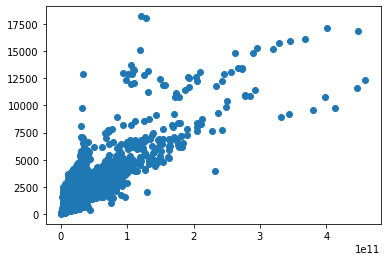

In [219]:
plt.scatter(pred, y_test)
plt.show()